# Task #7 Stock Market Prediction using Numerical and Textual Analysis by Shubham Wankar

## Objective: Create a hybrid model for stock price / performance prediction using numerical analysis of historical stock price, and sentimental analysis of news headlines

## Stock selected: NIFTY 50 Index

## Stock Historical Price Data: https://finance.yahoo.com/quote/%5ENSEI/history?p=%5ENSEI&guccounter=1

## News Data: https://bit.ly/36fFPI6

![image](https://images.unsplash.com/photo-1590283603385-17ffb3a7f29f?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80)

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, GRU
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Reading and examining the numerical and textual data

In [2]:
stock_data = pd.read_csv('^NSEI.csv')

In [3]:
news_data = pd.read_csv('india-news-headlines.csv')

In [4]:
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
news_data.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [6]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,16659.671757,16741.357446,16545.560094,16651.556420,16651.556420,340917.338710
std,1126.561195,1125.978107,1114.423734,1116.628668,1116.628668,118565.174606
min,14219.150391,14382.299805,14151.400391,14296.400391,14296.400391,0.000000
25%,15776.150391,15835.362305,15702.275146,15752.212891,15752.212891,255700.000000
50%,16974.525390,17151.025390,16838.549804,16994.474610,16994.474610,317650.000000
75%,17541.912110,17618.950683,17386.975098,17533.100586,17533.100586,418325.000000
max,18602.349609,18604.449219,18445.300781,18477.050781,18477.050781,650200.000000


In [7]:
news_data.describe()

,publish_date
count,3.650970e+06
mean,2.013193e+07
std,5.252282e+04
min,2.001010e+07
25%,2.010042e+07
50%,2.014023e+07
75%,2.017093e+07
max,2.022033e+07


## Data Cleaning

In [8]:
def calculate_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [9]:
def calculate_news_sentiment(news_data, start, end):
    
    # converting to datetime format
    news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], 
                                               format="%Y%m%d")
    # renaming to Date column
    news_data = news_data.rename(columns={'publish_date':'Date'})
    
    #masking the news to reduce computation
    mask = (news_data['Date'] >= start) & (news_data['Date'] <= end)
    news_data = news_data[mask]
    
    # calculating the required sentiment
    sid = SentimentIntensityAnalyzer()
    news_data['compound']  = [sid.polarity_scores(h)['compound'] for h in news_data['headline_text']]
    news_data['pos']  = [sid.polarity_scores(h)['pos'] for h in news_data['headline_text']]
    news_data['neu']  = [sid.polarity_scores(h)['neu'] for h in news_data['headline_text']]
    news_data['neg']  = [sid.polarity_scores(h)['neg'] for h in news_data['headline_text']]
    news_data['subjectivity'] = [calculate_subjectivity(h) for h in news_data['headline_text']]
    news_data['polarity'] = [calculate_polarity(h) for h in news_data['headline_text']]
    
    # calculating average sentiment for each date
    output = news_data.groupby(by='Date').mean()
    output = pd.DataFrame(output).reset_index()
    
    return output

In [10]:
def clean_data(stock_data, news_data):
    # initializing start and end dates
    start = stock_data['Date'].min()
    end = stock_data['Date'].max()
    
    # calculating news sentiment
    news_sentiment_data = calculate_news_sentiment(news_data, 
                                                   start, 
                                                   end)
    
    # converting the date column to datetime format 
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], 
                                        format="%Y-%m-%d")
    
    # merging the two dataframes on Date column
    final_data = stock_data.merge(news_sentiment_data, 
                                  on='Date', 
                                  how='left')
    
    # dropping unrequired column
    final_data = final_data.drop('Close', 
                                 axis=1)
    
    return final_data

In [11]:
final_data = clean_data(stock_data, news_data)

In [12]:
final_data.head()

,Date,Open,High,Low,Adj Close,Volume,compound,pos,neu,neg,subjectivity,polarity
0,2021-03-31,14811.849609,14813.750000,14670.250000,14690.700195,463900,-0.101050,0.058130,0.820338,0.121534,0.163219,0.013357
1,2021-04-01,14798.400391,14883.200195,14692.450195,14867.349609,445000,-0.070941,0.057547,0.842074,0.100385,0.171566,0.034521
2,2021-04-05,14837.700195,14849.849609,14459.500000,14637.799805,509700,-0.081638,0.061286,0.827724,0.110992,0.171236,0.009918
3,2021-04-06,14737.000000,14779.099609,14573.900391,14683.500000,475300,-0.087427,0.049716,0.838962,0.111328,0.167198,0.012697
4,2021-04-07,14716.450195,14879.799805,14649.849609,14819.049805,0,-0.056738,0.056860,0.846050,0.097088,0.174649,0.027640


## Visualizing the data

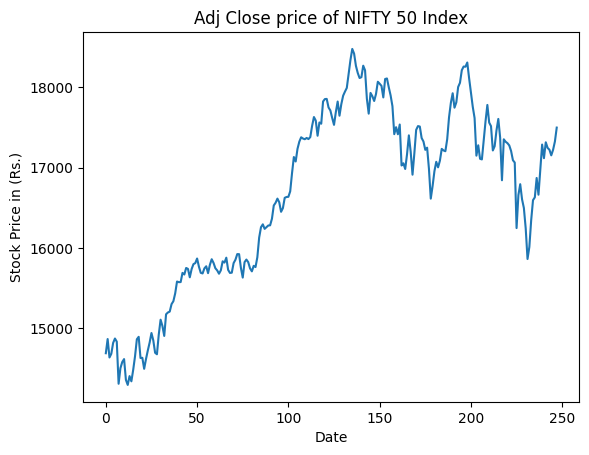

In [13]:
plt.plot(final_data['Adj Close'])
plt.title('Adj Close price of NIFTY 50 Index')
plt.xlabel('Date')
plt.ylabel('Stock Price in (Rs.)')
plt.show()

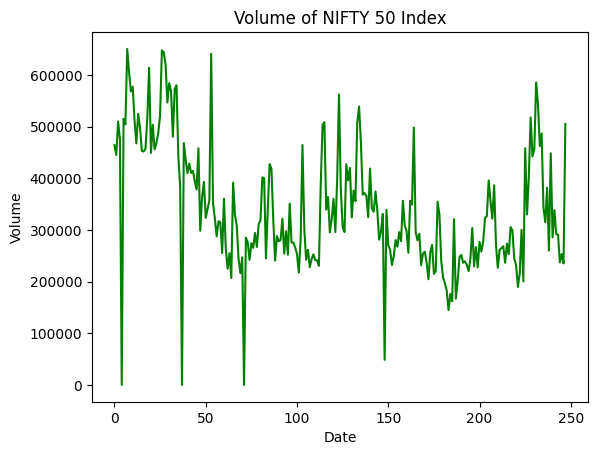

In [14]:
plt.plot(final_data['Volume'], 'g')
plt.title('Volume of NIFTY 50 Index')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

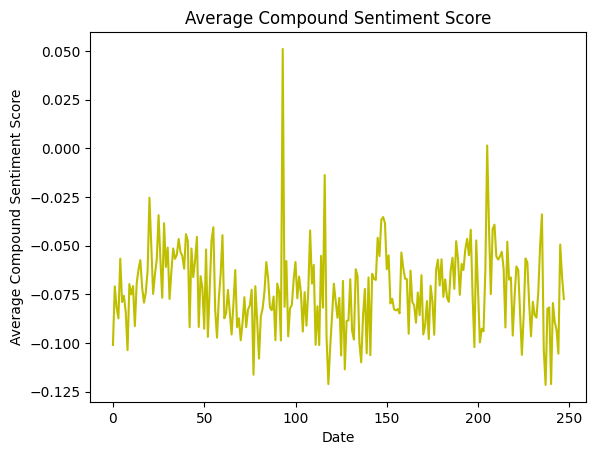

In [15]:
plt.plot(final_data['compound'], 'y')
plt.title('Average Compound Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Average Compound Sentiment Score')
plt.show()

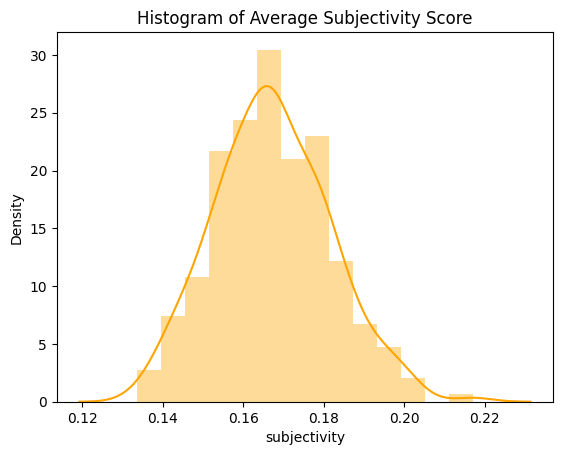

In [16]:
sns.distplot(final_data['subjectivity'], color='orange')
plt.title('Histogram of Average Subjectivity Score')
plt.show()

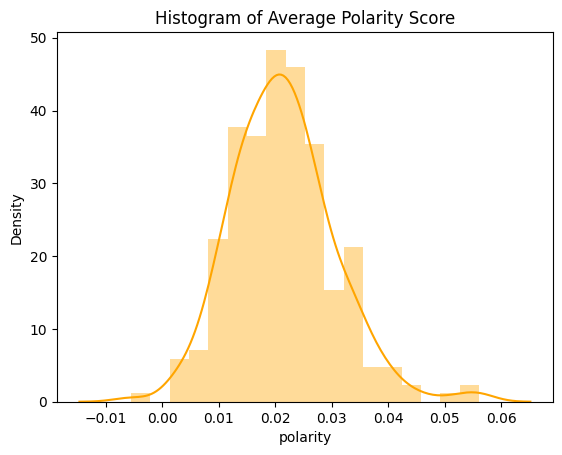

In [17]:
sns.distplot(final_data['polarity'], color='orange')
plt.title('Histogram of Average Polarity Score')
plt.show()

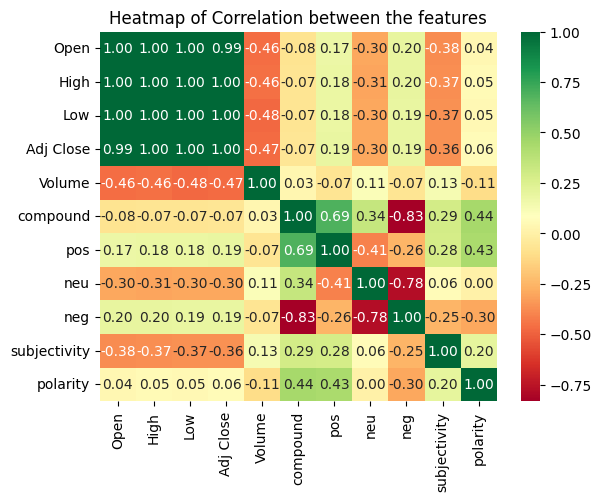

In [18]:
sns.heatmap(final_data.corr(), cmap='RdYlGn', annot=True, fmt='.2f')
plt.title("Heatmap of Correlation between the features")
plt.show()

#### Inference:
- Based on the above heatmap, we will be dropping columns (Open, High, Low, pos, neu and neg) since they have a high correlation with each other and Adj Close price will be the target variable

## Data Preprocessing

In [19]:
# Function for scaling and dividing data into X, y and Train-Test data
def preprocess_data_nn(data, 
                       train_split_ratio = 0.7,
                       scaler='standard',
                       timesteps=10):
    
    # Dropping date unrequired columns
    df = data.copy().drop(['Date', 'Open', 'High',
                          'Low', 'pos', 'neu',
                          'neg'], axis=1).values
    
    # Columns used are Adj Close, Volume, compound, subjectivity and polarity

    # Train index
    train_index = int(len(df) * train_split_ratio)
    
    # Scaling the data
    if scaler == 'standard':
        scalar = StandardScaler()
        scalar.fit(df[:train_index,:])
        scaled_data = scalar.transform(df)
        
    elif scaler == 'minmax':
        scalar = MinMaxScaler()
        scalar.fit(df[:train_index,:])
        scaled_data = scalar.transform(df)
        
    # Splitting data into X and y
    X = [] 
    y = []
    
    for t in range(timesteps, len(scaled_data)):
        X.append(scaled_data[t-timesteps:t,:])
        y.append(scaled_data[t])
        
    X = np.array(X)
    y = np.array(y)
    
    X_train, y_train = X[:train_index,:,:], y[:train_index,:]
    X_test, y_test = X[train_index:,:,:], y[train_index:,:]
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    return X_train, y_train, X_test, y_test, scalar


In [20]:
X_train, y_train, X_test, y_test, scalar = preprocess_data_nn(final_data,
                                                           scaler='standard')

(173, 10, 5)
(173, 5)
(65, 10, 5)
(65, 5)


## Model Building

### Conv LSTM Model
- Based on the research paper https://doi.org/10.1155/2020/6622927

In [21]:
# Building Conv LSTM Model
conv_lstm_model = Sequential(name='Conv_LSTM')
conv_lstm_model.add(InputLayer(input_shape = (X_train.shape[1],
                                              X_train.shape[2])))
conv_lstm_model.add(Conv1D(32, 1, 
                           activation='tanh', 
                           padding='same'))
conv_lstm_model.add(MaxPooling1D(pool_size=1,
                                 padding='same'))
conv_lstm_model.add(LSTM(100, 
                         return_sequences=True))
conv_lstm_model.add(Dropout(0.1))
conv_lstm_model.add(LSTM(100))
conv_lstm_model.add(Dense(5))
print(conv_lstm_model.summary())

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 10, 100)           53200     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                         

In [22]:
# Compiling and fitting the model
conv_lstm_model.compile(optimizer=Adam(0.001), 
                        loss='mean_absolute_error')

conv_lstm_model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
3/3 [==============================] - 9s 594ms/step - loss: 0.7849 - val_loss: 0.7991
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 0.6980 - val_loss: 0.7378
Epoch 3/100
3/3 [==============================] - 0s 43ms/step - loss: 0.6197 - val_loss: 0.7340
Epoch 4/100
3/3 [==============================] - 0s 48ms/step - loss: 0.6039 - val_loss: 0.7280
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5879 - val_loss: 0.7096
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.5712 - val_loss: 0.7081
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.5649 - val_loss: 0.7034
Epoch 8/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5568 - val_loss: 0.7055
Epoch 9/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5485 - val_loss: 0.7116
Epoch 10/100
3/3 [==============================] - 0s 40ms/step - loss: 0.5444 - val_loss: 0.7229
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 36ms/step - loss: 0.3892 - val_loss: 0.9288
Epoch 85/100
3/3 [==============================] - 0s 40ms/step - loss: 0.3833 - val_loss: 0.9261
Epoch 86/100
3/3 [==============================] - 0s 36ms/step - loss: 0.3846 - val_loss: 0.9354
Epoch 87/100
3/3 [==============================] - 0s 32ms/step - loss: 0.3820 - val_loss: 0.9340
Epoch 88/100
3/3 [==============================] - 0s 44ms/step - loss: 0.3910 - val_loss: 0.9484
Epoch 89/100
3/3 [==============================] - 0s 40ms/step - loss: 0.4047 - val_loss: 0.9373
Epoch 90/100
3/3 [==============================] - 0s 35ms/step - loss: 0.3942 - val_loss: 0.8947
Epoch 91/100
3/3 [==============================] - 0s 35ms/step - loss: 0.3836 - val_loss: 0.9416
Epoch 92/100
3/3 [==============================] - 0s 34ms/step - loss: 0.3810 - val_loss: 0.9281
Epoch 93/100
3/3 [==============================] - 0s 38ms/step - loss: 0.3689 - val_loss: 0.9382
Epoch 94/1

In [23]:
# Making predictions
predicted = scalar.inverse_transform(conv_lstm_model.predict(X_test))

3/3 [==============================] - 1s 6ms/step


In [24]:
# Creating a function to evaluate and plot the predicted vs actual data

def plot_predicted_data(final_data, predicted):
    index = predicted.shape[0]
    predicted_df = final_data[['Date', 'Adj Close']].iloc[-index:]
    predicted_df = predicted_df.reset_index()
    predicted_df = predicted_df.drop('index', axis=1)
    
    predicted_df['Predicted'] = predicted[:,0]
    
    predicted_df = predicted_df.set_index('Date')
    
    mae = mean_absolute_error(predicted_df['Adj Close'].values,
                             predicted_df['Predicted'])
    
    print("Mean Absolute Error:", round(mae, 2))
    
    plt.plot(predicted_df['Adj Close'], label='Actual')
    plt.plot(predicted_df['Predicted'], label='Predicted')
    plt.title('Predicted vs Actual Adj Close Price Plot')
    plt.xticks(rotation=45)
    plt.legend()
    plt.plot()

Mean Absolute Error: 383.99


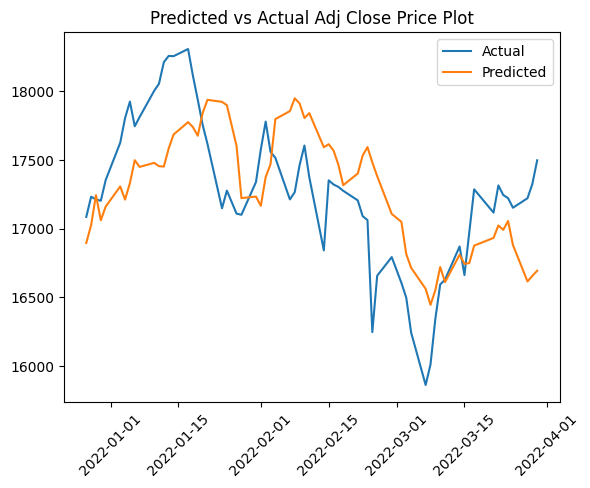

In [25]:
plot_predicted_data(final_data, predicted)

### LSTM Model

In [26]:
# Building LSTM Model
lstm_model = Sequential(name='LSTM')
lstm_model.add(InputLayer(input_shape=(X_train.shape[1], 
                                       X_train.shape[2])))
lstm_model.add(LSTM(100, 
                    return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(5))
print(lstm_model.summary())

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 100)           42400     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# Compiling and fitting the model
lstm_model.compile(optimizer=Adam(0.001), loss='mean_absolute_error')
lstm_model.fit(X_train, y_train, 
               batch_size=64, 
               epochs=100, 
               validation_data=(X_test, y_test), 
               shuffle=False)

Epoch 1/100
3/3 [==============================] - 3s 362ms/step - loss: 0.7478 - val_loss: 0.7744
Epoch 2/100
3/3 [==============================] - 0s 71ms/step - loss: 0.6696 - val_loss: 0.7180
Epoch 3/100
3/3 [==============================] - 0s 37ms/step - loss: 0.6113 - val_loss: 0.7010
Epoch 4/100
3/3 [==============================] - 0s 40ms/step - loss: 0.6023 - val_loss: 0.7006
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5857 - val_loss: 0.6948
Epoch 6/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5667 - val_loss: 0.7020
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5660 - val_loss: 0.7127
Epoch 8/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5637 - val_loss: 0.7183
Epoch 9/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5556 - val_loss: 0.7207
Epoch 10/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5508 - val_loss: 0.7173
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 28ms/step - loss: 0.4201 - val_loss: 0.9564
Epoch 85/100
3/3 [==============================] - 0s 31ms/step - loss: 0.4175 - val_loss: 0.9933
Epoch 86/100
3/3 [==============================] - 0s 31ms/step - loss: 0.4143 - val_loss: 1.0012
Epoch 87/100
3/3 [==============================] - 0s 28ms/step - loss: 0.4154 - val_loss: 1.0223
Epoch 88/100
3/3 [==============================] - 0s 27ms/step - loss: 0.4092 - val_loss: 1.0027
Epoch 89/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4127 - val_loss: 1.0145
Epoch 90/100
3/3 [==============================] - 0s 34ms/step - loss: 0.4127 - val_loss: 1.0270
Epoch 91/100
3/3 [==============================] - 0s 27ms/step - loss: 0.4161 - val_loss: 1.0004
Epoch 92/100
3/3 [==============================] - 0s 31ms/step - loss: 0.4052 - val_loss: 1.0291
Epoch 93/100
3/3 [==============================] - 0s 24ms/step - loss: 0.4057 - val_loss: 0.9922
Epoch 94/1

In [28]:
# Making predictions
lstm_predicted = scalar.inverse_transform(lstm_model.predict(X_test))

3/3 [==============================] - 1s 7ms/step


Mean Absolute Error: 371.64


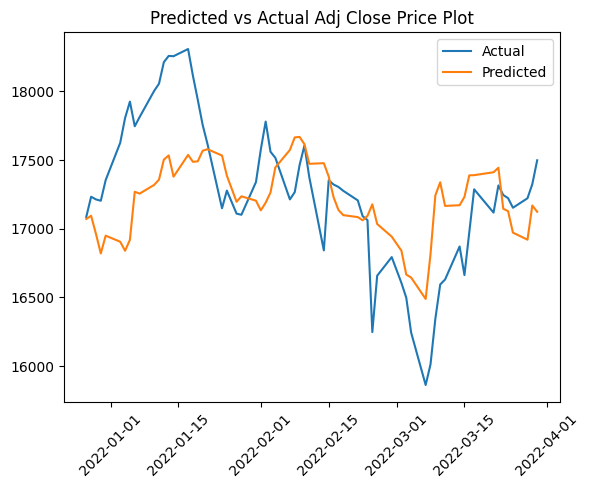

In [29]:
plot_predicted_data(final_data, lstm_predicted)

### CNN-GRU Model

In [30]:
# Building Conv GRU Model
conv_gru_model = Sequential(name='CNN_GRU')
conv_gru_model.add(InputLayer(input_shape = (X_train.shape[1],
                                             X_train.shape[2])))
conv_gru_model.add(Conv1D(32, 1, 
                          activation='tanh', 
                          padding='same'))
conv_gru_model.add(MaxPooling1D(pool_size=1,
                                padding='same'))
conv_gru_model.add(Conv1D(64, 1, 
                          activation='tanh', 
                          padding='same'))
conv_gru_model.add(MaxPooling1D(pool_size=1,
                                padding='same'))
conv_gru_model.add(GRU(100, 
                       return_sequences=True))
conv_gru_model.add(Dropout(0.1))
conv_gru_model.add(GRU(100))
conv_gru_model.add(Dense(5))
print(conv_gru_model.summary())

Model: "CNN_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 10, 32)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 64)            2112      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 10, 100)           49800     
                                                                 
 dropout_2 (Dropout)         (None, 10, 100)           0   

In [31]:
# Compiling and fitting the model
conv_gru_model.compile(optimizer=Adam(0.001), 
                       loss='mean_absolute_error')

conv_gru_model.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
3/3 [==============================] - 3s 293ms/step - loss: 0.7651 - val_loss: 0.7409
Epoch 2/100
3/3 [==============================] - 0s 39ms/step - loss: 0.6333 - val_loss: 0.6879
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5926 - val_loss: 0.6909
Epoch 4/100
3/3 [==============================] - 0s 42ms/step - loss: 0.5779 - val_loss: 0.6423
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5571 - val_loss: 0.6445
Epoch 6/100
3/3 [==============================] - 0s 35ms/step - loss: 0.5597 - val_loss: 0.6480
Epoch 7/100
3/3 [==============================] - 0s 34ms/step - loss: 0.5589 - val_loss: 0.6589
Epoch 8/100
3/3 [==============================] - 0s 41ms/step - loss: 0.5472 - val_loss: 0.6777
Epoch 9/100
3/3 [==============================] - 0s 39ms/step - loss: 0.5435 - val_loss: 0.6858
Epoch 10/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5432 - val_loss: 0.6643
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3188 - val_loss: 1.0343
Epoch 85/100
3/3 [==============================] - 0s 20ms/step - loss: 0.3214 - val_loss: 1.0581
Epoch 86/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3090 - val_loss: 1.0715
Epoch 87/100
3/3 [==============================] - 0s 30ms/step - loss: 0.3081 - val_loss: 1.1053
Epoch 88/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3095 - val_loss: 1.0959
Epoch 89/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3105 - val_loss: 1.0941
Epoch 90/100
3/3 [==============================] - 0s 24ms/step - loss: 0.3134 - val_loss: 1.1128
Epoch 91/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3112 - val_loss: 1.1484
Epoch 92/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2991 - val_loss: 1.1331
Epoch 93/100
3/3 [==============================] - 0s 24ms/step - loss: 0.3069 - val_loss: 1.1283
Epoch 94/1

In [32]:
# Making predictions
conv_gru_predicted = scalar.inverse_transform(conv_gru_model.predict(X_test))

3/3 [==============================] - 1s 8ms/step


Mean Absolute Error: 306.12


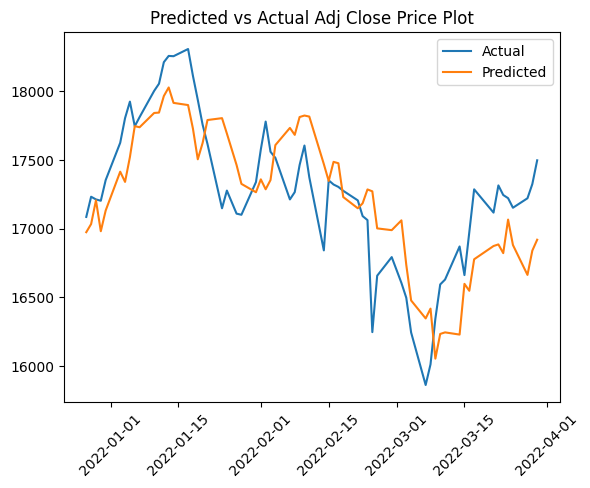

In [33]:
plot_predicted_data(final_data, conv_gru_predicted)

### GRU Model

In [34]:
# Building GRU Model
gru_model = Sequential(name='GRU')
gru_model.add(InputLayer(input_shape=(X_train.shape[1],
                                      X_train.shape[2])))
gru_model.add(GRU(100, 
                  return_sequences=True))
gru_model.add(Dropout(0.1))
gru_model.add(GRU(100))
gru_model.add(Dense(5))
print(gru_model.summary())

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 10, 100)           32100     
                                                                 
 dropout_3 (Dropout)         (None, 10, 100)           0         
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 93,205
Trainable params: 93,205
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Compiling and fitting the model
gru_model.compile(optimizer=Adam(0.001),
                  loss='mean_absolute_error')
gru_model.fit(X_train, y_train, 
               batch_size=64, 
               epochs=100, 
               validation_data=(X_test, y_test), 
               shuffle=False)

Epoch 1/100
3/3 [==============================] - 3s 324ms/step - loss: 0.7634 - val_loss: 0.7376
Epoch 2/100
3/3 [==============================] - 0s 39ms/step - loss: 0.6401 - val_loss: 0.7088
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 0.6079 - val_loss: 0.7143
Epoch 4/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5913 - val_loss: 0.6705
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5624 - val_loss: 0.6571
Epoch 6/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5597 - val_loss: 0.6576
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5585 - val_loss: 0.6543
Epoch 8/100
3/3 [==============================] - 0s 32ms/step - loss: 0.5523 - val_loss: 0.6557
Epoch 9/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5468 - val_loss: 0.6540
Epoch 10/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5432 - val_loss: 0.6570
Epoch 11/100
3/3 [

Epoch 84/100
3/3 [==============================] - 0s 35ms/step - loss: 0.3838 - val_loss: 0.9132
Epoch 85/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3833 - val_loss: 0.9138
Epoch 86/100
3/3 [==============================] - 0s 32ms/step - loss: 0.3823 - val_loss: 0.9103
Epoch 87/100
3/3 [==============================] - 0s 29ms/step - loss: 0.3832 - val_loss: 0.9284
Epoch 88/100
3/3 [==============================] - 0s 32ms/step - loss: 0.3791 - val_loss: 0.9358
Epoch 89/100
3/3 [==============================] - 0s 37ms/step - loss: 0.3886 - val_loss: 0.9276
Epoch 90/100
3/3 [==============================] - 0s 25ms/step - loss: 0.3799 - val_loss: 0.9323
Epoch 91/100
3/3 [==============================] - 0s 28ms/step - loss: 0.3780 - val_loss: 0.9429
Epoch 92/100
3/3 [==============================] - 0s 36ms/step - loss: 0.3756 - val_loss: 0.9404
Epoch 93/100
3/3 [==============================] - 0s 31ms/step - loss: 0.3708 - val_loss: 0.9308
Epoch 94/1

In [36]:
# Making predictions
gru_predicted = scalar.inverse_transform(gru_model.predict(X_test))

3/3 [==============================] - 1s 8ms/step


Mean Absolute Error: 321.18


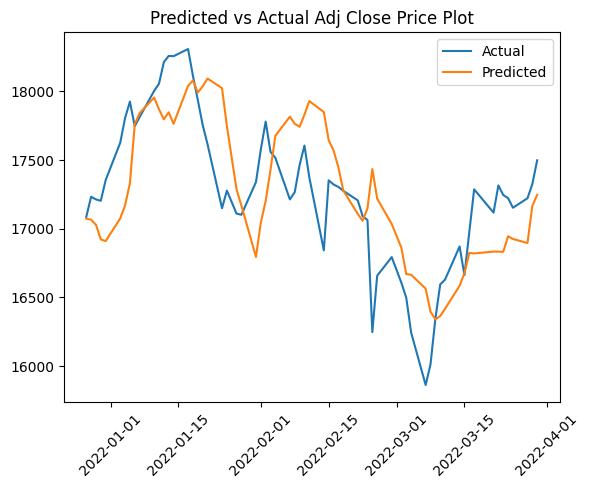

In [37]:
plot_predicted_data(final_data, gru_predicted)

## Conclusions 
- The actual price prediction of stock is a highly challenging task due to the stochastic and volatile nature of stock market.
- After testing out different models, the CNN-GRU / GRU Model seems to perform best in predicting the movement of the stock.
- For future, we can try implementing Deep Reinforcement Algorithms to this problem